## **Libraries imported**

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
# from sklearn_pandas import CategoricalImputer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
colorlist= plt.rcParams['axes.prop_cycle'].by_key()['color']
from pylab import rcParams
import os
import warnings
warnings.filterwarnings('ignore')

### Read Data

In [3]:
train = pd.read_csv(r"..\Data\train.psv.gz", compression='gzip', sep = "|")

### Distribution of Dependent Variable

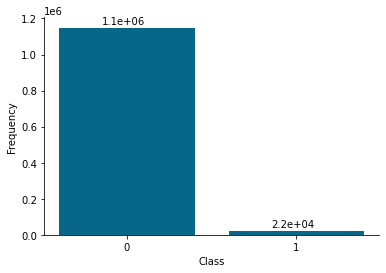

In [26]:
fig, ax = plt.subplots()
ax.bar(train['SepsisLabel'].value_counts().index,
       train['SepsisLabel'].value_counts())
ax.set_xticks([0,1])
ax.set_xlabel('Class')
# ax.set_title('Sepsis Label Distribution')
ax.set_ylabel('Frequency')
for p in ax.patches:
    ax.annotate('{:.2g}'.format(p.get_height()), (p.get_x() + 0.25, p.get_height() + 20000))
plt.savefig(r"..\Figures\Label_dist.pdf")

### Check For null in Features/ Independent variables

As we can see from the plot, it is a case of severe class imbalance . There are multiple methods that we could try to balance it (Over sampling or Undersampling) or even proceed without balancing but change the evaluation metric to average precision or roc_auc_sore

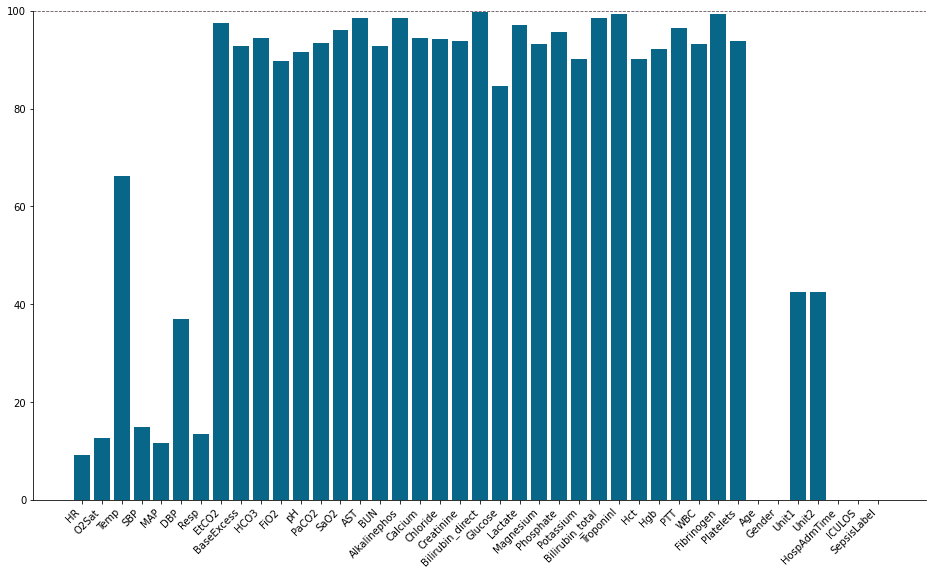

In [20]:
missing = (train.isnull().sum() / train.shape[0]) * 100

fig, ax = plt.subplots(figsize = (16, 9))

ax.bar(missing.index, missing)
ax.set_xticklabels(missing.index, rotation = 45, ha = 'right')
ax.set_ylim(bottom = 0, top = 100)

plt.axhline(y = 100, color = colorlist[2], linewidth = 0.8, linestyle = '--')
plt.savefig(r"..\Figures\var_missing_hist.pdf")

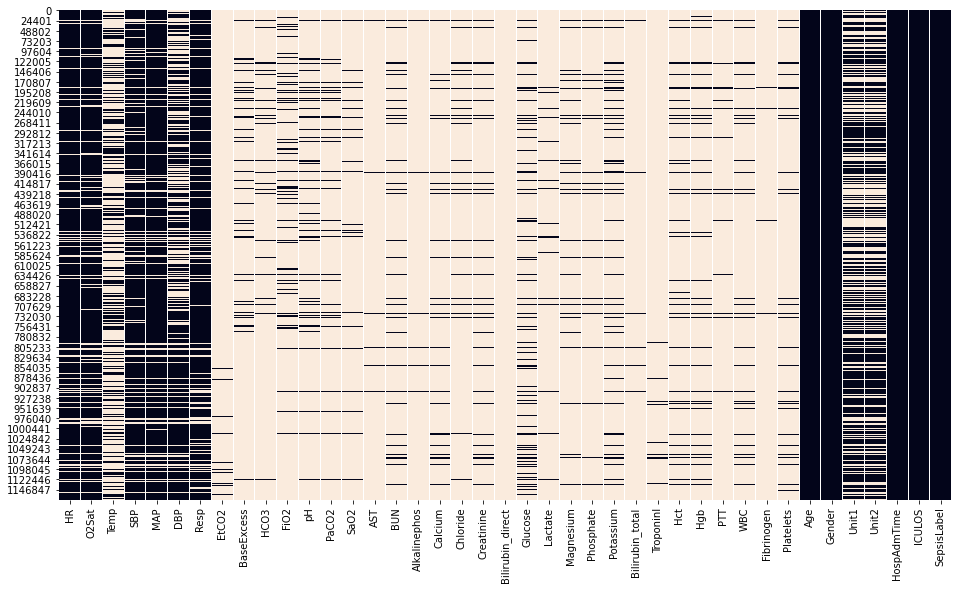

In [14]:
fig, ax = plt.subplots(figsize = (16, 9))
sns.heatmap(train.isnull(), cbar=False, ax = ax)
plt.savefig(r"..\Figures\var_missing.pdf")

In [21]:
selected_cols = list(missing[missing < 90].index)

filter_train = train[selected_cols]

### Univariate plots

In [16]:
categorical = filter_train.dtypes == object
categorical['Unit1'] = True
categorical['Unit2'] = True
categorical['Gender'] = True

cat_vars = list(categorical[categorical].index)
cont_vars = list(categorical[~categorical].index)

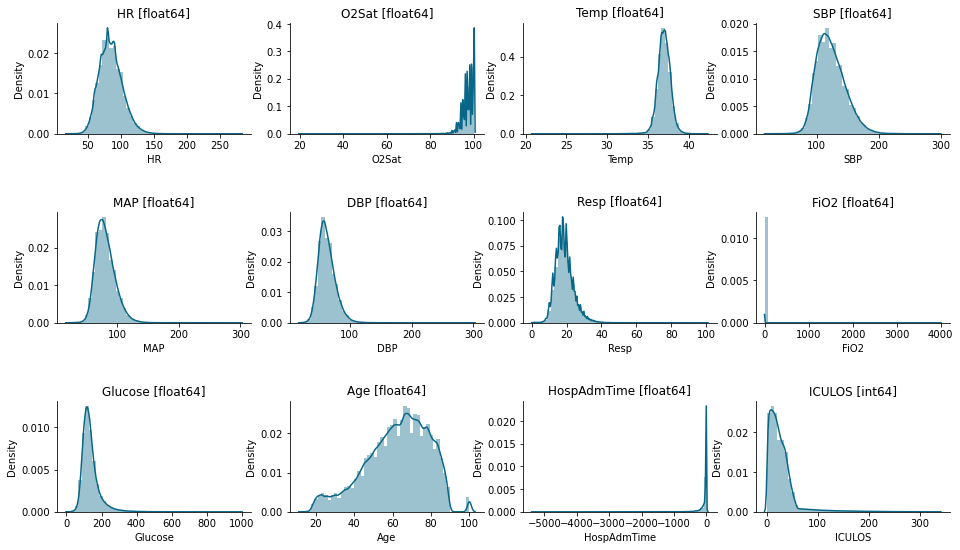

In [69]:
fig, ax = plt.subplots((len(cont_vars))//4, 4, figsize = (16, 9))
fig.subplots_adjust(hspace = 0.7)
for i, var in enumerate(cont_vars[:-1]):
    x, y = i//4, i%4
    var_type = filter_train[var].dtypes
    ax[x, y].set_title(f"{var} [{var_type}]")
    ax[x, y].set_xlabel(str(var))
    sns.distplot(filter_train[var].dropna(), ax = ax[x, y])
    
plt.savefig(r"..\Figures\var_dists.pdf")

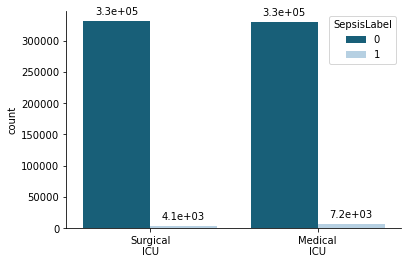

In [25]:
fig, ax = plt.subplots()
sns.countplot(filter_train['Unit1'].dropna(), hue='SepsisLabel', data = filter_train, ax = ax)
ax.set_xticklabels(["Surgical\nICU", "Medical\nICU"])
ax.set_xlabel("")
for p in ax.patches:
    ax.annotate('{:.2g}'.format(p.get_height()), (p.get_x() + 0.07, p.get_height() + 10000))
plt.savefig(r"..\Figures\label_ICU.pdf")

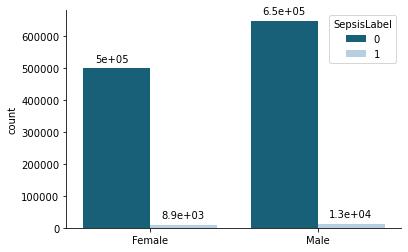

In [23]:
fig, ax = plt.subplots()
sns.countplot(filter_train['Gender'].dropna(), hue='SepsisLabel', data = filter_train, ax = ax)
ax.set_xticklabels(["Female", "Male"])
ax.set_xlabel("")
for p in ax.patches:
    ax.annotate('{:.2g}'.format(p.get_height()), (p.get_x() + 0.07, p.get_height() + 20000))
plt.savefig(r"..\Figures\label_per_sex.pdf")

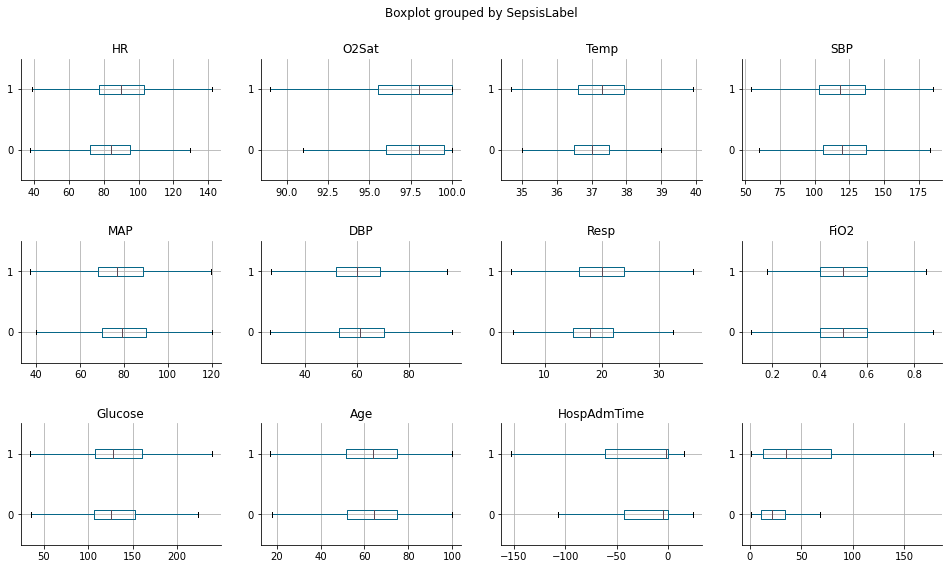

In [74]:
fig, ax = plt.subplots((len(cont_vars))//4, 4, figsize = (16, 9))
fig.subplots_adjust(hspace = 0.5)
for i, var in enumerate(cont_vars[:-1]):
    x, y = i//4, i%4
    filter_train.boxplot(var, by = 'SepsisLabel', ax = ax[x, y], vert = False, showfliers=False)
    ax[x, y].set_xlabel("")
    
plt.title("")
plt.savefig(r"..\Figures\box_per_var.pdf")

In [64]:
train.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [73]:
columns_OI.keys()

dict_keys(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'FiO2', 'Glucose', 'ICULOS', 'Unit 1', 'Age', 'Gender', 'HospAdmTime'])

In [81]:
# Get a table with descriptives of the data
columns_OI = {
    'HR': "Heart Rate (bpm)", 'O2Sat': "Pulse oximetry (%)",
    'Temp': "Temperature (Celsius)", 'SBP': "Systolic blood pressure (mm Hg)",
    'MAP': "Mean arterial pressure (mm Hg)", 'DBP': "Diastolic blood pressure (mm Hg)",
    'Resp': "Respiration Rate (bpm)", 'FiO2': "Fraction of inspired oxygen (%)",
    'Glucose': "Serum glucose (mg/dL)", 'ICULOS': "ICU length-of-stay",
    'Unit 1': "Type of ICU", 'Age': "Age", 'Gender': "Gender", 
    'HospAdmTime': "Hospital Admission Time"
    }

temp = train[columns_OI.keys())]

temp

AttributeError: 'dict_keys' object has no attribute 'to_list'

In [66]:
# Get a table with descriptives of the data
columns_OI = {
    'HR': "Heart Rate (bpm)", 'O2Sat': "Pulse oximetry (%)",
    'Temp': "Temperature (Celsius)", 'SBP': "Systolic blood pressure (mm Hg)",
    'MAP': "Mean arterial pressure (mm Hg)", 'DBP': "Diastolic blood pressure (mm Hg)",
    'Resp': "Respiration Rate (bpm)", 'FiO2': "Fraction of inspired oxygen (%)",
    'Glucose': "Serum glucose (mg/dL)", 'ICULOS': "ICU length-of-stay",
    'Unit 1': "Type of ICU", 'Age': "Age", 'Gender': "Gender", 
    'HospAdmTime': "Hospital Admission Time"
    }

temp = train \
    .describe() \
    .transpose() \
    .rename(columns = columns_OI) \
#     [columns_OI.values()]

temp['% missing'] = 1 - temp['count']/train.shape[0]

temp.to_latex(
    r"..\Tables\tab_describe.tex",
    columns = ['mean', 'std', 'min', '50%', 'max', '% missing'],
    header = ['Mean', 'Standard Deviation', 'Minimum', 'Median', 'Maximum', 'Percent Missing'],
    float_format = "%2.2f",
    column_format = "l" + "c"*6,
    caption = "Summary Statistics",
    label = "tab_describe",
    longtable = True
)

KeyError: "None of [Index(['Heart Rate (bpm)', 'Pulse oximetry (%)', 'Temperature (Celsius)',\n       'Systolic blood pressure (mm Hg)', 'Mean arterial pressure (mm Hg)',\n       'Diastolic blood pressure (mm Hg)', 'Respiration Rate (bpm)',\n       'Fraction of inspired oxygen (%)', 'Serum glucose (mg/dL)',\n       'ICU length-of-stay', 'Type of ICU', 'Age', 'Gender',\n       'Hospital Admission Time'],\n      dtype='object')] are in the [columns]"

## **Baseline**

The Features which are used for basleline. No Feature engineering has been done yet 

In [0]:
features = cont_vars + cat_vars
features

['HR',
 'O2Sat',
 'Temp',
 'SBP',
 'MAP',
 'DBP',
 'Resp',
 'FiO2',
 'Glucose',
 'Age',
 'HospAdmTime',
 'ICULOS',
 'Gender',
 'Unit1',
 'Unit2']

In [0]:
X_train = filter_train[features]
y_train = filter_train['SepsisLabel']

In [0]:
categorical = X_train.dtypes == object
categorical['Unit1'] = True
categorical['Unit2'] = True
categorical['Gender'] = True

In [0]:
cont_scale_pipeline = make_pipeline(SimpleImputer(strategy = "median"), 
                                    StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy = "constant", 
                                           fill_value = 999), 
                             OneHotEncoder(handle_unknown="ignore"))
preprocess_trans_scale = make_column_transformer((cont_scale_pipeline, 
                                                  ~categorical), 
                                                 (cat_pipeline, categorical))

In [0]:
logistic_pipe_scale = make_pipeline(preprocess_trans_scale, 
                                    LogisticRegression(solver='lbfgs') )
rf_pipe_scale = make_pipeline(preprocess_trans_scale, RandomForestClassifier())
svc_pipe_scale = make_pipeline(preprocess_trans_scale, SVC())
gb_pipe_scale = make_pipeline(preprocess_trans_scale, GradientBoostingClassifier())
dt_pipe_scale = make_pipeline(preprocess_trans_scale, DecisionTreeClassifier() )
gmm_pipe_scale = make_pipeline(preprocess_trans_scale, GaussianMixture(n_components=2))
mlp_pipe_scale = make_pipeline(preprocess_trans_scale, MLPClassifier() )

In [0]:
scores_logistic_pipe_scale = cross_validate(logistic_pipe_scale, X_train, 
                                             y_train, 
                                             cv=StratifiedKFold(3, shuffle=True)
                                             ,scoring=["average_precision", 
                                                       "roc_auc", "precision", 
                                                       "recall"])



scores_rf_pipe_scale = cross_validate(rf_pipe_scale, X_train, 
                                             y_train, 
                                             cv=StratifiedKFold(3, shuffle=True)
                                             ,scoring=["average_precision", 
                                                       "roc_auc", "precision", 
                                                       "recall"])



scores_gb_pipe_scale = cross_validate(gb_pipe_scale, X_train, 
                                             y_train, 
                                             cv=StratifiedKFold(3, shuffle=True)
                                             ,scoring=["average_precision", 
                                                       "roc_auc", "precision", 
                                                       "recall"])



scores_dt_pipe_scale = cross_validate(dt_pipe_scale, X_train, 
                                             y_train, 
                                             cv=StratifiedKFold(3, shuffle=True)
                                             ,scoring=["average_precision", 
                                                       "roc_auc", "precision", 
                                                       "recall"])


scores_gmm_pipe_scale = cross_validate(gmm_pipe_scale, X_train, 
                                             y_train, 
                                             cv=StratifiedKFold(3, shuffle=True)
                                             ,scoring=["average_precision", 
                                                       "roc_auc", "precision", 
                                                       "recall"])

scores_mlp_pipe_scale = cross_validate(mlp_pipe_scale, X_train, 
                                             y_train, 
                                             cv=StratifiedKFold(3, shuffle=True)
                                             ,scoring=["average_precision", 
                                                       "roc_auc", "precision", 
                                                       "recall"])

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
log_df = pd.DataFrame(scores_logistic_pipe_scale)
log_df['model'] = 'LogisticRegression'

dt_df = pd.DataFrame(scores_dt_pipe_scale)
dt_df['model'] = 'DecisionTree'

gb_df = pd.DataFrame(scores_gb_pipe_scale)
gb_df['model'] = 'GradientBoosting'

rf_df = pd.DataFrame(scores_rf_pipe_scale)
rf_df['model'] = 'RandomForest'

gmm_df = pd.DataFrame(scores_gmm_pipe_scale)
gmm_df['model'] = 'GMM'

mlp_df = pd.DataFrame(scores_mlp_pipe_scale)
mlp_df['model'] = 'MLP'




results = pd.concat([log_df, dt_df, gb_df, rf_df, gmm_df, mlp_df])

In [0]:
results

,fit_time,score_time,test_average_precision,test_roc_auc,test_precision,test_recall,model
0,7.611157,2.017487,0.071857,0.727672,0.191781,0.001862,LogisticRegression
1,8.142756,1.995413,0.073176,0.727376,0.225490,0.003059,LogisticRegression
2,5.138180,2.000983,0.070523,0.722542,0.244444,0.002926,LogisticRegression
0,20.830284,2.095555,0.137285,0.680937,0.332473,0.376779,DecisionTree
1,22.150067,2.105724,0.128715,0.672709,0.323020,0.359622,DecisionTree
2,20.925736,2.096886,0.110077,0.659345,0.290483,0.334530,DecisionTree
0,200.444403,4.612183,0.117531,0.785900,0.723404,0.009044,GradientBoosting
1,207.409091,4.555136,0.116421,0.790547,0.537037,0.007714,GradientBoosting
2,198.840454,4.586021,0.120006,0.792486,0.674157,0.007981,GradientBoosting
0,32.893491,5.748398,0.300345,0.828571,0.850455,0.086980,RandomForest
